### Unsupervise Multivariate Anomaly Detection with Time Series 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

import tensorflow as tf

In [2]:
# Import Current Voltage data
cv_data = pd.read_csv('../data/CurrentVoltage.csv')
cv_data['DeviceTimeStamp'] = pd.to_datetime(cv_data['DeviceTimeStamp'])

cv_data = cv_data[cv_data.duplicated() == False]

print(cv_data.shape)

(19320, 11)


In [3]:
# Import Frequency data
frequency_data = pd.read_csv('../data/frequency.csv')
frequency_data['DeviceTimeStamp'] = pd.to_datetime(frequency_data['DeviceTimeStamp'])
frequency_data = frequency_data[frequency_data.duplicated() == False]

In [4]:
frequency_data.head()

DeviceTimeStamp   FRQ
0 2019-06-25 12:39:00   0.0
1 2019-06-25 12:41:00   0.0
2 2019-06-25 13:05:00   0.0
3 2019-06-27 10:50:00  49.9
4 2019-06-27 10:51:00  50.0

In [5]:
merged_df = pd.merge_asof(cv_data,frequency_data,on='DeviceTimeStamp', tolerance=pd.Timedelta('1m'))

In [6]:
merged_df[merged_df.FRQ.isnull()].head()

DeviceTimeStamp    VL1    VL2    VL3  IL1  IL2  IL3  VL12  VL23  VL31  \
1   2019-06-27 10:49:00  238.7  238.7  238.8  0.0  0.0  0.0   0.0   0.0   0.0   
8   2019-06-27 11:00:00  241.1  241.2  241.2  0.0  0.0  0.0   0.0   0.0   0.0   
40  2019-06-27 11:50:00  239.7  239.8  239.8  0.0  0.0  0.0   0.0   0.0   0.0   
67  2019-06-27 12:14:00  238.3  238.4  238.4  0.0  0.0  0.0   0.0   0.0   0.0   
117 2019-06-27 12:58:00  238.3  238.3  238.3  0.0  0.0  0.0   0.0   0.0   0.0   

     INUT  FRQ  
1     0.0  NaN  
8     0.0  NaN  
40    0.0  NaN  
67    0.0  NaN  
117   0.0  NaN

In [7]:
feature_column = ['VL1', 'VL2', 'VL3', 'IL1', 'IL2', 'IL3', 'VL12','VL23', 'VL31', 'INUT', 'FRQ']
time_column = 'DeviceTimeStamp'

In [8]:
# Imputation of frequency based on nearest neighbour. Considering 5 as of now, can be improved based on model diagnostics check.

imputer = KNNImputer(n_neighbors=5)
imputation_values = imputer.fit_transform(merged_df[feature_column])

imputed_merged_df = pd.DataFrame(imputation_values,columns=feature_column)


In [9]:
imputed_merged_df.iloc[merged_df[merged_df.FRQ.isnull()].index].head()

VL1    VL2    VL3  IL1  IL2  IL3  VL12  VL23  VL31  INUT    FRQ
1    238.7  238.7  238.8  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.96
8    241.1  241.2  241.2  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.98
40   239.7  239.8  239.8  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.92
67   238.3  238.4  238.4  0.0  0.0  0.0   0.0   0.0   0.0   0.0  50.00
117  238.3  238.3  238.3  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.98

In [10]:
imputed_merged_df.head()

VL1    VL2    VL3  IL1  IL2  IL3  VL12  VL23  VL31  INUT    FRQ
0    0.0    0.0    0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.00
1  238.7  238.7  238.8  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.96
2  238.4  238.5  238.5  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.90
3  239.9  240.0  240.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.90
4  241.1  241.2  241.2  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.90

In [11]:
imputed_merged_df[time_column] = merged_df.DeviceTimeStamp

In [12]:
# Extract date, hour, minutes, months, DayOfWeek, year

imputed_merged_df['Date'] = imputed_merged_df.DeviceTimeStamp.dt.date
imputed_merged_df['Hour'] = imputed_merged_df.DeviceTimeStamp.dt.hour
imputed_merged_df['Minutes'] = imputed_merged_df.DeviceTimeStamp.dt.minute

imputed_merged_df['Month'] = imputed_merged_df.DeviceTimeStamp.dt.month
imputed_merged_df['DayOfWeek'] = imputed_merged_df.DeviceTimeStamp.dt.dayofweek

In [13]:
# Note:
#For 1st time stamp, Line-Vtg,Line-Line vtg and Current is 0. When can we expect this condition? 
# For 2nd time step onwards, even though vtg value is available, no current,means load is zero. When can we expect this?
imputed_merged_df.head()

VL1    VL2    VL3  IL1  IL2  IL3  VL12  VL23  VL31  INUT    FRQ  \
0    0.0    0.0    0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.00   
1  238.7  238.7  238.8  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.96   
2  238.4  238.5  238.5  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.90   
3  239.9  240.0  240.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.90   
4  241.1  241.2  241.2  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.90   

      DeviceTimeStamp        Date  Hour  Minutes  Month  DayOfWeek  
0 2019-06-25 13:06:00  2019-06-25    13        6      6          1  
1 2019-06-27 10:49:00  2019-06-27    10       49      6          3  
2 2019-06-27 10:51:00  2019-06-27    10       51      6          3  
3 2019-06-27 10:52:00  2019-06-27    10       52      6          3  
4 2019-06-27 10:53:00  2019-06-27    10       53      6          3

In [14]:
# Data collected between which period
print('Data collected for time period: {}'.format(imputed_merged_df.DeviceTimeStamp.iloc[-1] - imputed_merged_df.DeviceTimeStamp.iloc[0]))
print('Start date : {}'.format(imputed_merged_df.DeviceTimeStamp.iloc[0]))
print('End date : {}'.format(imputed_merged_df.DeviceTimeStamp.iloc[-1]))

Data collected for time period: 293 days 11:24:00
Start date : 2019-06-25 13:06:00
End date : 2020-04-14 00:30:00


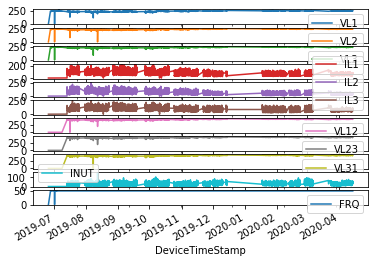

In [15]:
# High level view of the data

# Data in initial time stamps looks to have zero current and line to line voltage and also line voltage is increaing steeply
# Many places we see stratight lines - data not available for certain days in between
# Many places spikes in line voltage , which means some abnormality is present.


plot_features = imputed_merged_df[feature_column]
plot_features.index = imputed_merged_df['DeviceTimeStamp']
_ = plot_features.plot(subplots=True)

In [16]:
# Zero FRQ points. require handling. ALl the values are zero. 
imputed_merged_df[imputed_merged_df.FRQ == 0]

VL1  VL2  VL3  IL1  IL2  IL3  VL12  VL23  VL31  INUT  FRQ  \
0     0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   
1297  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   
1298  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  0.0   

         DeviceTimeStamp        Date  Hour  Minutes  Month  DayOfWeek  
0    2019-06-25 13:06:00  2019-06-25    13        6      6          1  
1297 2019-07-01 11:37:00  2019-07-01    11       37      7          0  
1298 2019-07-01 11:45:00  2019-07-01    11       45      7          0

# Objective:

- Identify the system data collection behavior
- Identify the abnormality present in the dataset - Case by case as triggers for abnormality. It is essential to not only flag abnormality but also classify the category of abnormality
- CLean the dataset with abnormalities as the objective of the model would be to learn high probablity region and flag in case of any abnormalities

# Understanding frequency of data collection process

In [17]:
imputed_merged_df['data_collection_frequency'] = imputed_merged_df.DeviceTimeStamp - imputed_merged_df.DeviceTimeStamp.shift(1)

In [18]:
# Day wise Frequency

# Q: Why do we see so much gaps in data collection - Is the Anomolous data already removed or device was not under use?
# Q: What is reason behind not having data for larger gaps like: 33 days, 14 days, 7 days, 5 days

imputed_merged_df.data_collection_frequency.dt.days.value_counts(ascending=False)

0.0     19301
1.0         7
4.0         4
2.0         2
14.0        1
7.0         1
5.0         1
33.0        1
3.0         1
Name: data_collection_frequency, dtype: int64

In [19]:
# Hour wise frequency

# Data collection frequency greater than 1 hour : Around 60 points with greater than 1 hr gap in collection : Why ?

# 61 data points transition with time gap >= 1 hour.

(imputed_merged_df.data_collection_frequency/np.timedelta64(1,'h') >= 1).value_counts()

False    19259
True        61
Name: data_collection_frequency, dtype: int64

In [20]:
# Minutewise frequency

# Most of the data is collected in interval of 15 min.
# Incases where the minute gap is different than 15 min, is it because of event gets triggered on value change or
# configuration change for data collection in operation or because of some unknown process ? Requires analysis to make initial 
# assumption. Ideally, sensors are event based triggers and timmers are set to send values in case value does not change for 
# max threshold time limit.

minute_frequency = (imputed_merged_df.data_collection_frequency/np.timedelta64(1,'m')).value_counts(normalize=False)

minute_frequency_normalized = (imputed_merged_df.data_collection_frequency/np.timedelta64(1,'m')).value_counts(normalize=True)
for k,v in minute_frequency_normalized.items():
    if v>=0.001:
        print('Minute: {}, Proportion: {}'.format(k,v))

Minute: 15.0, Proportion: 0.864433976913919
Minute: 1.0, Proportion: 0.048190900150111286
Minute: 0.0, Proportion: 0.020963818003002226
Minute: 14.0, Proportion: 0.006211501630519178
Minute: 16.0, Proportion: 0.005124488845178322
Minute: 13.0, Proportion: 0.0049174387908276825
Minute: 12.0, Proportion: 0.0037786634918991666
Minute: 17.0, Proportion: 0.003726900978311507
Minute: 3.0, Proportion: 0.003468088410373208
Minute: 5.0, Proportion: 0.0032610383560225686
Minute: 2.0, Proportion: 0.00284693824732129
Minute: 10.0, Proportion: 0.00284693824732129
Minute: 7.0, Proportion: 0.00274341322014597
Minute: 6.0, Proportion: 0.002588125679382991
Minute: 11.0, Proportion: 0.0024328381386200114
Minute: 9.0, Proportion: 0.0024328381386200114
Minute: 4.0, Proportion: 0.0023810756250323517
Minute: 8.0, Proportion: 0.0023293131114446915
Minute: 18.0, Proportion: 0.0020705005435063925
Minute: 19.0, Proportion: 0.0010870127853408562
Minute: 30.0, Proportion: 0.0010870127853408562


In [21]:
# Seconds Frequency
(imputed_merged_df.data_collection_frequency/np.timedelta64(1,'s')).value_counts(normalize=False)

900.0      16700
60.0         931
0.0          405
840.0        120
960.0         99
           ...  
6480.0         1
1980.0         1
13980.0        1
7500.0         1
71100.0        1
Name: data_collection_frequency, Length: 109, dtype: int64

In [22]:
# Second Specific is in sync with minutes, so dropping seconds from time stamp
imputed_merged_df.DeviceTimeStamp = imputed_merged_df.DeviceTimeStamp.dt.floor('Min')
imputed_merged_df.data_collection_frequency = imputed_merged_df.data_collection_frequency.dt.floor('Min')
imputed_merged_df.head()

VL1    VL2    VL3  IL1  IL2  IL3  VL12  VL23  VL31  INUT    FRQ  \
0    0.0    0.0    0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.00   
1  238.7  238.7  238.8  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.96   
2  238.4  238.5  238.5  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.90   
3  239.9  240.0  240.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.90   
4  241.1  241.2  241.2  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.90   

      DeviceTimeStamp        Date  Hour  Minutes  Month  DayOfWeek  \
0 2019-06-25 13:06:00  2019-06-25    13        6      6          1   
1 2019-06-27 10:49:00  2019-06-27    10       49      6          3   
2 2019-06-27 10:51:00  2019-06-27    10       51      6          3   
3 2019-06-27 10:52:00  2019-06-27    10       52      6          3   
4 2019-06-27 10:53:00  2019-06-27    10       53      6          3   

  data_collection_frequency  
0                       NaT  
1           1 days 21:43:00  
2           0 days 00:02:00  
3           0 days 00:01:00  
4           0 days 00:01:00

In [23]:
# Data cluster based on minute frequency
(imputed_merged_df.data_collection_frequency/np.timedelta64(1,'m'))

0           NaN
1        2743.0
2           2.0
3           1.0
4           1.0
          ...  
19315      15.0
19316      15.0
19317      15.0
19318      15.0
19319      15.0
Name: data_collection_frequency, Length: 19320, dtype: float64

In [24]:
# Creating to store cluster start and stop index based on minutes
class ClusterTimeRange:
    def __init__(self):
        self.__start_index = None
        self.__stop_index = None
        self.__minute = None
        
    @property
    def start_index(self):
        return self.__start_index
    
    @start_index.setter
    def start_index(self,value):
        self.__start_index = value
        
    @property
    def stop_index(self):
        return self.__stop_index
    
    @stop_index.setter
    def stop_index(self,value):
        self.__stop_index = value
        
    @property
    def minute(self):
        return self.__minute
    
    @minute.setter
    def minute(self,value):
        self.__minute = value      

In [25]:
# Create Time frequency based cluster for analysis

list_cluster_timerange = list()
start_index = None
end_index = None
min_frequency = imputed_merged_df.data_collection_frequency/np.timedelta64(1,'m')
cluster_time_instance = ClusterTimeRange()
for k,v in min_frequency.items():
    if cluster_time_instance.start_index == None:
        #print('Start index: {}'.format(k))
        cluster_time_instance.start_index = k
        cluster_time_instance.minute = v
    elif cluster_time_instance.minute is not None and cluster_time_instance.minute != v:
        cluster_time_instance.stop_index = k
        #print('Minute: {}'.format(cluster_time_instance.minute))        
        #print('Stop index: {}'.format(v))
        list_cluster_timerange.append(cluster_time_instance)        
        cluster_time_instance = ClusterTimeRange()
    else:
        continue       
        
cluster_dict = {k:[v.start_index, v.stop_index, v.minute ] for k,v in enumerate(list_cluster_timerange)}
cluster_df = pd.DataFrame.from_dict(cluster_dict).T
cluster_df.columns = ['start_index', 'stop_index', 'Minutes']

In [26]:
print('Cluster Count: {}'.format(cluster_df.shape[0]))
cluster_df.head()

Cluster Count: 1517


start_index  stop_index  Minutes
0          0.0         1.0      NaN
1          2.0         3.0      2.0
2          4.0         6.0      1.0
3          7.0         8.0      1.0
4          9.0        10.0      1.0

## Reduce Cluster Size based on abnormal conditions identified in the data


In [27]:
# Case 1: where Load current and line to line vtg is zero i.e. 'IL1', 'IL2', 'IL3', 'VL12', 'VL23', 'VL31', 'INUT'

indexs_with_load_current_zero = list()

load_features = ['IL1', 'IL2', 'IL3', 'VL12', 'VL23', 'VL31', 'INUT']

load_zero_df = imputed_merged_df.copy()
for feature in load_features:
    load_zero_df = load_zero_df[load_zero_df[feature] == 0.0]
print('Load zero DF: {}'.format(load_zero_df.shape[0]))

load_zero_df.tail()

Load zero DF: 1536


VL1    VL2    VL3  IL1  IL2  IL3  VL12  VL23  VL31  INUT   FRQ  \
1644  242.0  242.1  242.1  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.9   
1645  241.6  241.6  241.6  0.0  0.0  0.0   0.0   0.0   0.0   0.0  49.9   
1646  242.5  242.6  242.6  0.0  0.0  0.0   0.0   0.0   0.0   0.0  50.0   
1647  242.1  242.1  242.1  0.0  0.0  0.0   0.0   0.0   0.0   0.0  50.1   
1648  242.9  242.9  242.9  0.0  0.0  0.0   0.0   0.0   0.0   0.0  50.1   

         DeviceTimeStamp        Date  Hour  Minutes  Month  DayOfWeek  \
1644 2019-07-08 11:47:00  2019-07-08    11       47      7          0   
1645 2019-07-08 11:47:00  2019-07-08    11       47      7          0   
1646 2019-07-08 11:51:00  2019-07-08    11       51      7          0   
1647 2019-07-08 11:54:00  2019-07-08    11       54      7          0   
1648 2019-07-08 11:57:00  2019-07-08    11       57      7          0   

     data_collection_frequency  
1644           0 days 00:17:00  
1645           0 days 00:00:00  
1646           0 days 00:04:00  
1647           0 days 00:03:00  
1648           0 days 00:03:00

In [28]:
# We can see even after load current 0 in few of the cases current value is just 0.2 and no line to line voltage.
imputed_merged_df.iloc[1648:1700]

VL1    VL2    VL3    IL1   IL2    IL3   VL12   VL23   VL31  INUT  \
1648  242.9  242.9  242.9    0.0   0.0    0.0    0.0    0.0    0.0   0.0   
1649  243.3  243.4  243.4    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1650  241.6  241.7  241.7    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1651  241.5  241.5  241.6    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1652  242.1  242.2  242.2    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1653  242.0  242.0  242.0    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1654  242.7  242.7  242.8    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1655  241.1  241.2  241.2    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1656  242.1  242.2  242.2    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1657  242.0  242.1  242.1    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1658  241.1  241.2  241.2    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1659  241.3  241.4  241.4    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1660  241.6  241.7  241.7    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1661  241.3  241.3  241.4    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1662  241.3  241.4  241.4    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1663  244.0  244.1  244.1    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1664  243.8  243.9  243.9    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1665  244.2  244.3  244.3    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1666  244.4  244.5  244.5    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1667  243.8  243.9  243.9    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1668  243.6  243.7  243.7    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1669  243.9  243.9  244.0    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1670  243.9  244.0  244.0    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1671  244.4  244.5  244.5    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1672  243.4  243.5  243.5    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1673  245.6  245.7  245.7    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1674  245.5  245.6  245.6    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1675  244.1  244.2  244.2    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1676  244.3  244.3  244.4    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1677  244.6  244.7  244.7    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1678  244.3  244.4  244.4    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1679  243.8  243.8  243.9    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1680  243.5  243.6  243.6    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1681  243.3  243.4  243.4    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1682  243.6  243.6  243.7    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1683  243.5  243.5  243.5    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1684  243.4  243.5  243.5    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1685  243.6  243.6  243.7    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1686  243.8  243.8  243.8    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1687  243.4  243.4  243.5    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1688  242.8  242.9  242.9    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1689  243.2  243.3  243.3    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1690  243.4  243.5  243.5    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1691  243.3  243.4  243.4    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1692  243.1  243.2  243.2    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1693  243.6  243.7  243.7    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1694  244.1  244.2  244.2    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1695  244.0  244.1  244.1    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1696  243.1  243.1  243.1    0.2   0.2    0.2    0.0    0.0    0.0   0.0   
1697  233.2  233.7  233.0    1.1   0.9    1.1  405.5  405.3  405.2   0.1   
1698  233.4  233.8  233.3    1.2   1.1    1.3  403.7  403.6  403.5   0.1   
1699  233.4  234.0  232.8  108.5  98.7  139.8  405.0  40

In [29]:
# Clustering all Zero Load in cluster_df

cluster_load_zero = cluster_df[cluster_df.stop_index <= 1648]
print('Load Zer0 Cluster')
cluster_load_zero

Load Zer0 Cluster


start_index  stop_index  Minutes
0            0.0         1.0      NaN
1            2.0         3.0      2.0
2            4.0         6.0      1.0
3            7.0         8.0      1.0
4            9.0        10.0      1.0
..           ...         ...      ...
514       1631.0      1637.0     15.0
515       1638.0      1639.0   2458.0
516       1640.0      1642.0     15.0
517       1643.0      1644.0     14.0
518       1645.0      1646.0      0.0

[519 rows x 3 columns]

In [30]:
# Dropping zero Load cluster
cluster_df = cluster_df.drop(cluster_load_zero.index,0)

In [31]:
print('Remaining Clusters: {}'.format(cluster_df.shape))


Remaining Clusters: (998, 3)


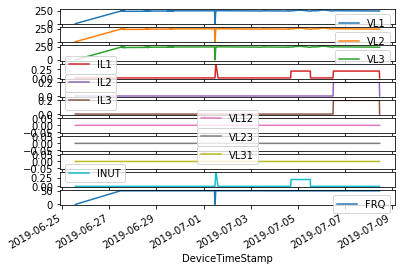

In [32]:
# Visualize Load zero cluster. We need special handling for these scenarios.
start_ind = int(cluster_load_zero.iloc[0].start_index)
stop_ind = int(cluster_load_zero.iloc[-1].stop_index)

plot_features = imputed_merged_df.iloc[start_ind:stop_ind][feature_column]
plot_features.index = imputed_merged_df.iloc[start_ind:stop_ind]['DeviceTimeStamp']
_ = plot_features.plot(subplots=True)

In [33]:
# Case 2: zero line to line voltages i.e.  'VL12', 'VL23', 'VL31'


indexs_with_line_to_line_vtg_zero = list()

load_features = ['VL12', 'VL23', 'VL31', 'INUT']

line_toline_zero_df = imputed_merged_df.copy()
for feature in load_features:
    line_toline_zero_df = line_toline_zero_df[line_toline_zero_df[feature] == 0.0]
print('Line to Line zero DF: {}'.format(line_toline_zero_df.shape[0]))

Line to Line zero DF: 1608


In [34]:
line_toline_zero_df.tail()

VL1    VL2    VL3  IL1  IL2  IL3  VL12  VL23  VL31  INUT    FRQ  \
1692  243.1  243.2  243.2  0.2  0.2  0.2   0.0   0.0   0.0   0.0  49.80   
1693  243.6  243.7  243.7  0.2  0.2  0.2   0.0   0.0   0.0   0.0  49.80   
1694  244.1  244.2  244.2  0.2  0.2  0.2   0.0   0.0   0.0   0.0  49.80   
1695  244.0  244.1  244.1  0.2  0.2  0.2   0.0   0.0   0.0   0.0  49.96   
1696  243.1  243.1  243.1  0.2  0.2  0.2   0.0   0.0   0.0   0.0  49.90   

         DeviceTimeStamp        Date  Hour  Minutes  Month  DayOfWeek  \
1692 2019-07-08 14:28:00  2019-07-08    14       28      7          0   
1693 2019-07-08 14:29:00  2019-07-08    14       29      7          0   
1694 2019-07-08 14:30:00  2019-07-08    14       30      7          0   
1695 2019-07-08 14:59:00  2019-07-08    14       59      7          0   
1696 2019-07-08 15:15:00  2019-07-08    15       15      7          0   

     data_collection_frequency  
1692           0 days 00:00:00  
1693           0 days 00:01:00  
1694           0 days 00:01:00  
1695           0 days 00:29:00  
1696           0 days 00:16:00

In [35]:
# Map to cluster df
# Clustering all Zero Load in cluster_df
cluster_line_to_line_vtg_zero = cluster_df[cluster_df.stop_index <= line_toline_zero_df.index[-1]]

# Dropping line to line vtg zero cluster
cluster_df = cluster_df.drop(cluster_line_to_line_vtg_zero.index,0)

In [36]:
cluster_df

start_index  stop_index  Minutes
542        1696.0      1697.0     16.0
543        1698.0      1699.0      1.0
544        1700.0      1701.0     10.0
545        1702.0      1713.0     15.0
546        1714.0      1716.0     12.0
...           ...         ...      ...
1512      19224.0     19225.0     16.0
1513      19226.0     19248.0     15.0
1514      19249.0     19250.0      2.0
1515      19251.0     19289.0     15.0
1516      19290.0     19291.0     14.0

[975 rows x 3 columns]

In [37]:
cluster_line_to_line_vtg_zero_df = imputed_merged_df.loc[int(cluster_line_to_line_vtg_zero.iloc[0].start_index):int(cluster_line_to_line_vtg_zero.iloc[-1].stop_index)]

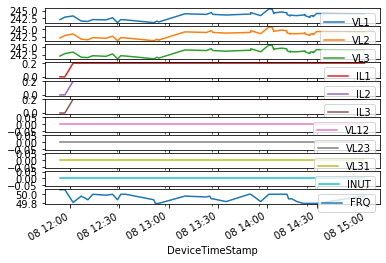

In [38]:
# Voltage Line-Line is zero
# current 0.2 can be seen. Needs to identify in which scenario this happens.
# Frequency too has high variance

start_ind = int(cluster_line_to_line_vtg_zero.iloc[0].start_index)
stop_ind = int(cluster_line_to_line_vtg_zero.iloc[-1].stop_index)

plot_features = imputed_merged_df.loc[start_ind:stop_ind][feature_column]
plot_features.index = imputed_merged_df.loc[start_ind:stop_ind]['DeviceTimeStamp']
_ = plot_features.plot(subplots=True)

In [39]:
#case3: Split data based on day gap greater than 1 day

index_day_greater_than_1 = [i for i in imputed_merged_df[imputed_merged_df.data_collection_frequency.dt.days >= 1].index if i >= int(cluster_df.iloc[0].start_index)]

In [40]:
print(index_day_greater_than_1)

[1697, 2769, 3442, 4893, 7106, 9365, 11521, 12215, 13194, 13330, 14861, 15470, 16479, 17306, 17323]


In [41]:
imputed_merged_df.loc[index_day_greater_than_1]

VL1    VL2    VL3    IL1    IL2    IL3   VL12   VL23   VL31  INUT  \
1697   233.2  233.7  233.0    1.1    0.9    1.1  405.5  405.3  405.2   0.1   
2769   234.5  233.5  234.3  109.2   89.4  128.7  405.6  405.0  408.0  34.5   
3442   228.3  227.0  228.5  107.1  119.3  131.4  393.9  394.6  397.6  19.7   
4893   226.4  224.7  225.9  132.1   97.0  157.3  390.1  388.9  392.5  52.9   
7106   233.2  235.9  232.2  129.7   98.4  119.9  406.2  405.8  402.2  27.4   
9365   240.3  239.8  237.7  118.9   81.0  107.0  415.5  412.9  414.5  33.6   
11521  244.2  243.3  242.6  100.5   61.4  103.9  422.6  419.9  422.5  41.0   
12215  242.3  243.6  241.5   98.0   52.2   96.9  420.9  419.4  420.4  45.7   
13194  247.2  247.0  245.6   91.2   50.5   92.1  428.2  425.8  427.8  41.1   
13330  249.4  249.0  247.3   84.6   54.3   83.1  431.5  429.3  431.2  24.2   
14861  246.5  245.3  243.1   97.7   94.8  142.0  425.5  422.5  426.0  45.8   
15470  243.7  241.6  240.9  100.9   88.3  135.9  420.1  417.3  422.0  42.4   
16479  243.5  244.0  242.8   50.1   49.5   74.4  421.6  422.5  420.1  24.9   
17306  240.3  241.9  239.5  130.0   58.2  114.1  418.2  415.4  417.5  64.6   
17323  242.8  244.0  241.3  109.2   50.0  107.0  421.7  418.4  421.0  58.2   

         FRQ     DeviceTimeStamp        Date  Hour  Minutes  Month  DayOfWeek  \
1697   49.90 2019-07-13 11:51:00  2019-07-13    11       51      7          5   
2769   49.90 2019-07-30 15:54:00  2019-07-30    15       54      7          1   
3442   49.80 2019-08-07 15:54:00  2019-08-07    15       54      8          2   
4893   49.90 2019-08-26 15:44:00  2019-08-26    15       44      8          0   
7106   50.00 2019-09-26 13:50:00  2019-09-26    13       50      9          3   
9365   49.94 2019-10-24 16:17:00  2019-10-24    16       17     10          3   
11521  50.00 2019-11-21 13:09:00  2019-11-21    13        9     11          3   
12215  50.00 2019-11-30 11:42:00  2019-11-30    11       42     11          5   
13194  49.80 2019-12-13 14:44:00  2019-12-13    14       44     12          4   
13330  49.90 2020-01-17 14:39:00  2020-01-17    14       39      1          4   
14861  49.90 2020-02-03 17:30:00  2020-02-03    17       30      2          0   
15470  49.90 2020-02-12 17:54:00  2020-02-12    17       54      2          2   
16479  50.00 2020-02-27 11:16:00  2020-02-27    11       16      2          3   
17306  49.90 2020-03-21 14:41:00  2020-03-21    14       41      3          5   
17323  49.80 2020-03-23 17:00:00  2020-03-23    17        0      3          0   

      data_collection_frequency  
1697            4 days 20:36:00  
2769            5 days 04:39:00  
3442            1 days 00:24:00  
4893            3 days 15:44:00  
7106            7 days 13:50:00  
9365            4 days 16:17:00  
11521           4 days 12:54:00  
12215           1 days 10:27:00  
13194           2 days 22:59:00  
13330          33 days 14:39:00  
14861           1 days 03:45:00  
15470           2 days 17:39:00  
16479           4 days 04:24:00  
17306          14 days 14:26:00  
17323           1 days 22:23:00

In [42]:
# creating seperate cluster for these day gaps
cluster_df_dict = dict()
for i, index_ in enumerate(index_day_greater_than_1 ):
    if i+1 < len(index_day_greater_than_1):
        cluster_name = 'cluster_' + str(i)
        cluster_df_dict[cluster_name] = imputed_merged_df.loc[index_day_greater_than_1[i]:index_day_greater_than_1[i+1]]
        cluster_df_dict[cluster_name] = cluster_df_dict[cluster_name].drop([index_day_greater_than_1[i+1]],0)
        

In [43]:
# We get 14 different clusters based on day gaps in the dataset.
# which means that 14 events happened which might have resulted in long failure. 
# Need to identify the reason for all these gaps. 

for k,v in cluster_df_dict.items():
    print('Cluster: {}, shape:{}'.format(k,v.shape))

Cluster: cluster_0, shape:(1072, 18)
Cluster: cluster_1, shape:(673, 18)
Cluster: cluster_2, shape:(1451, 18)
Cluster: cluster_3, shape:(2213, 18)
Cluster: cluster_4, shape:(2259, 18)
Cluster: cluster_5, shape:(2156, 18)
Cluster: cluster_6, shape:(694, 18)
Cluster: cluster_7, shape:(979, 18)
Cluster: cluster_8, shape:(136, 18)
Cluster: cluster_9, shape:(1531, 18)
Cluster: cluster_10, shape:(609, 18)
Cluster: cluster_11, shape:(1009, 18)
Cluster: cluster_12, shape:(827, 18)
Cluster: cluster_13, shape:(17, 18)


# Day gap - Clusterwise analysis

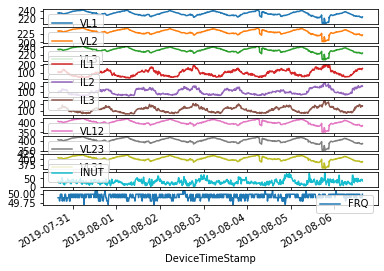

In [44]:
# On analysis on cluster basis we can see a lot abnormalities and also gap exists in terms if time interval when data is shared


data = cluster_df_dict['cluster_1']
plot_features = data[feature_column]
plot_features.index = data['DeviceTimeStamp']
_ = plot_features.plot(subplots=True)

## Hour gap based clusters

In [45]:
# This includes day gaps as well
index_hour_greater_than_1 = [i for i in imputed_merged_df[imputed_merged_df.data_collection_frequency/np.timedelta64(1,'h') >= 1].index if i >= int(cluster_df.iloc[0].start_index)]

In [46]:
# creating seperate cluster for these gaps

cluster_df_dict_basedon_hour_gap = dict()
for i, index_ in enumerate(index_hour_greater_than_1 ):
    if i+1 < len(index_hour_greater_than_1):
        cluster_name = 'cluster_' + str(i)
        cluster_df_dict_basedon_hour_gap[cluster_name] = imputed_merged_df.loc[index_hour_greater_than_1[i]:index_hour_greater_than_1[i+1]]
        cluster_df_dict_basedon_hour_gap[cluster_name] = cluster_df_dict_basedon_hour_gap[cluster_name].drop([index_hour_greater_than_1[i+1]],0)
        


In [47]:
# Clearly 14 day based clusters can be seperately again grouped into 47 clusters. 
# Hourly gap along with day gap collectd here points to total 47 short(hr) and long(day) events that might have resulted in
# missing out data. Needs to identify root cause behind this. 
# For now assuming data present here have been collected without any incorrectness.

# Some of the clusters have points in single digit. Ideally, while selecting window if it does not fit the window slide, cluster 
# will be not considered for training model.  

print('Hour Based Clusters: \n')
for k,v in cluster_df_dict_basedon_hour_gap.items():
    print('Cluster Name: {}, Cluster Shape: {}'.format(k,v.shape))

Hour Based Clusters: 

Cluster Name: cluster_0, Cluster Shape: (63, 18)
Cluster Name: cluster_1, Cluster Shape: (145, 18)
Cluster Name: cluster_2, Cluster Shape: (72, 18)
Cluster Name: cluster_3, Cluster Shape: (54, 18)
Cluster Name: cluster_4, Cluster Shape: (116, 18)
Cluster Name: cluster_5, Cluster Shape: (383, 18)
Cluster Name: cluster_6, Cluster Shape: (6, 18)
Cluster Name: cluster_7, Cluster Shape: (233, 18)
Cluster Name: cluster_8, Cluster Shape: (596, 18)
Cluster Name: cluster_9, Cluster Shape: (77, 18)
Cluster Name: cluster_10, Cluster Shape: (415, 18)
Cluster Name: cluster_11, Cluster Shape: (935, 18)
Cluster Name: cluster_12, Cluster Shape: (65, 18)
Cluster Name: cluster_13, Cluster Shape: (36, 18)
Cluster Name: cluster_14, Cluster Shape: (49, 18)
Cluster Name: cluster_15, Cluster Shape: (514, 18)
Cluster Name: cluster_16, Cluster Shape: (1115, 18)
Cluster Name: cluster_17, Cluster Shape: (6, 18)
Cluster Name: cluster_18, Cluster Shape: (529, 18)
Cluster Name: cluster_19, Cl

# Analysis of Data Distribution

In [48]:
data = imputed_merged_df[feature_column].loc[int(cluster_df.iloc[0].start_index):int(cluster_df.iloc[-1].stop_index)]

In [49]:
# Min value : VL12, VL31 has zero value. IL1	IL2,IL3	 has zero value
# Very high std dev for current 

data.describe()

VL1           VL2           VL3           IL1           IL2  \
count  17596.000000  17596.000000  17596.000000  17596.000000  17596.000000   
mean     241.022033    240.411088    239.745482     80.938878     64.782837   
std        9.387500      9.677910      8.595999     35.865366     37.751434   
min      112.600000      0.000000     90.100000      0.000000      0.000000   
25%      234.600000    234.300000    234.400000     52.700000     37.000000   
50%      243.000000    242.400000    241.100000     73.700000     53.750000   
75%      247.800000    246.900000    245.500000    103.700000     87.125000   
max      258.100000    257.000000    256.500000    224.100000    253.600000   

                IL3          VL12          VL23          VL31          INUT  \
count  17596.000000  17596.000000  17596.000000  17596.000000  17596.000000   
mean      91.384144    416.672602    415.634906    417.215577     28.871778   
std       36.669480     17.272533     15.238747     16.951961     13.261632   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       62.200000    405.800000    406.000000    406.675000     19.400000   
50%       85.300000    420.200000    418.400000    420.250000     27.100000   
75%      118.025000    428.300000    426.000000    428.500000     36.900000   
max      247.300000    446.500000    444.800000    447.300000    145.800000   

                FRQ  
count  17596.000000  
mean      49.948463  
std        0.067791  
min       49.600000  
25%       49.900000  
50%       50.000000  
75%       50.000000  
max       50.200000

In [50]:
# Dropping zero scenarios

data = data.drop(data[(data['VL12'] == 0.0) | (data['VL31'] == 0.0) | (data['IL1'] == 0.0) | (data['IL2'] == 0.0) | (data['IL2'] == 0.0)].index,0)

In [51]:
# Still high standard dev for IL1,IL2,IL3
data.describe()

VL1           VL2           VL3           IL1           IL2  \
count  17584.000000  17584.000000  17584.000000  17584.000000  17584.000000   
mean     241.051496    240.422623    239.769313     80.976376     64.800990   
std        9.208711      9.630241      8.425003     35.834751     37.725128   
min      128.500000      0.000000     90.100000      1.100000      0.900000   
25%      234.600000    234.300000    234.400000     52.700000     37.000000   
50%      243.000000    242.400000    241.100000     73.700000     53.800000   
75%      247.800000    246.900000    245.500000    103.700000     87.125000   
max      258.100000    257.000000    256.500000    224.100000    253.600000   

                IL3          VL12          VL23          VL31          INUT  \
count  17584.000000  17584.000000  17584.000000  17584.000000  17584.000000   
mean      91.416976    416.736294    415.679009    417.316504     28.882484   
std       36.633113     16.666918     14.871437     15.739872     13.249740   
min        1.100000     68.600000    189.500000     28.300000      0.000000   
25%       62.300000    405.800000    406.000000    406.700000     19.400000   
50%       85.350000    420.300000    418.400000    420.300000     27.100000   
75%      118.025000    428.300000    426.000000    428.500000     36.900000   
max      247.300000    446.500000    444.800000    447.300000    145.800000   

                FRQ  
count  17584.000000  
mean      49.948479  
std        0.067802  
min       49.600000  
25%       49.900000  
50%       50.000000  
75%       50.000000  
max       50.200000

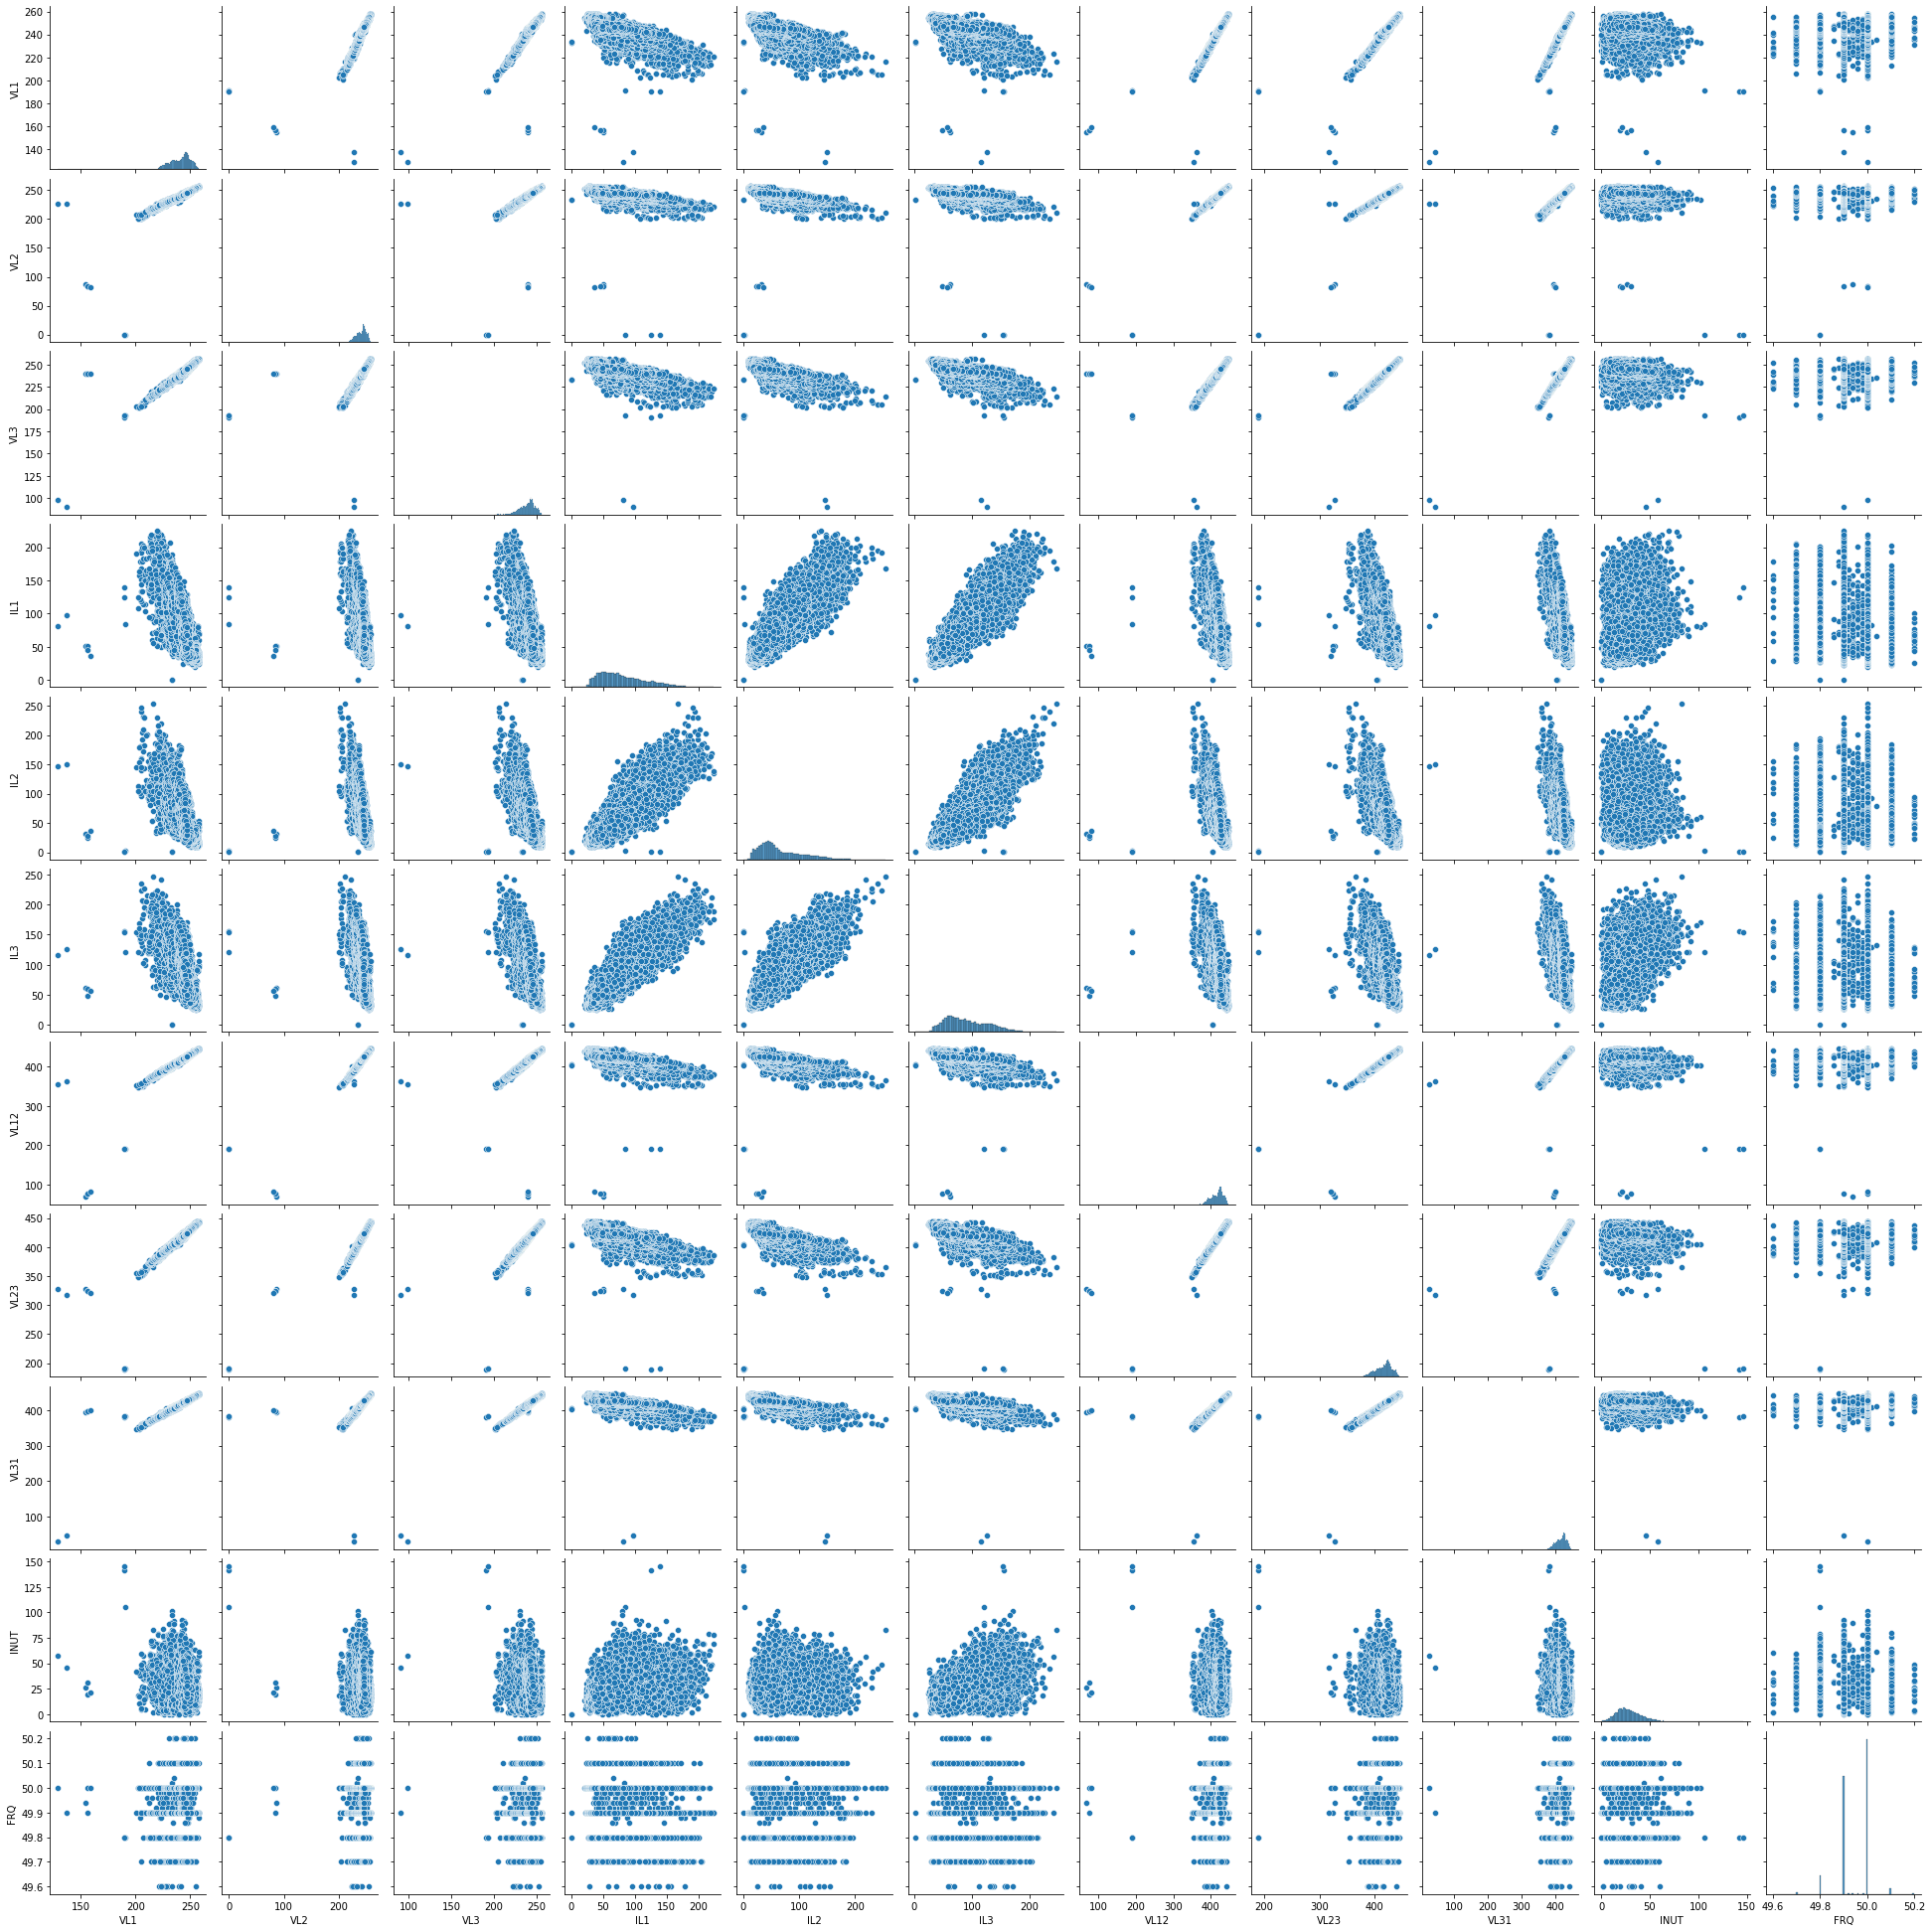

In [52]:
# clearly we can see a lot of noise in the dataset. We need to flag outlier's and generate high density region.
sns.pairplot(data)

In [53]:
std_scaler = StandardScaler()
data_transformed = std_scaler.fit_transform(data)
data_transformed_df = pd.DataFrame(data_transformed,columns=feature_column)
data_transformed_df.columns = feature_column
data_transformed_df.index = data.index


In [54]:
# VL1, VL2 and VL3 have data points within 3 std dev. VL2 has some points more than 2 std away.
# IL1, IL2, IL2 have very high variance. Points fall outside +- 2 std_dev away.
# Vl12, VL23, VL31 is also skewed

# To Handle this situation ideally, we must be clear with what is normal operation condition for each of the parameters

data_transformed_df.describe()

VL1           VL2           VL3           IL1           IL2  \
count  1.758400e+04  1.758400e+04  1.758400e+04  1.758400e+04  1.758400e+04   
mean  -4.525750e-16  1.849092e-15  9.568728e-16 -3.361986e-16  3.620600e-16   
std    1.000028e+00  1.000028e+00  1.000028e+00  1.000028e+00  1.000028e+00   
min   -1.222263e+01 -2.496609e+01 -1.776540e+01 -2.229083e+00 -1.693906e+00   
25%   -7.006061e-01 -6.357885e-01 -6.373251e-01 -7.890994e-01 -7.369565e-01   
50%    2.115996e-01  2.053358e-01  1.579495e-01 -2.030594e-01 -2.916174e-01   
75%    7.328600e-01  6.726271e-01  6.802193e-01  6.341406e-01  5.917712e-01   
max    1.851398e+00  1.721436e+00  1.985894e+00  3.994103e+00  5.004738e+00   

                IL3          VL12          VL23          VL31          INUT  \
count  1.758400e+04  1.758400e+04  1.758400e+04  1.758400e+04  1.758400e+04   
mean   1.939607e-16 -3.452501e-15  3.491293e-15  6.982586e-16  1.357725e-16   
std    1.000028e+00  1.000028e+00  1.000028e+00  1.000028e+00  1.000028e+00   
min   -2.465516e+00 -2.088846e+01 -1.520939e+01 -2.471606e+01 -2.179915e+00   
25%   -7.948493e-01 -6.561864e-01 -6.508641e-01 -6.745166e-01 -7.156935e-01   
50%   -1.656192e-01  2.138252e-01  1.829728e-01  1.895556e-01 -1.345336e-01   
75%    7.263587e-01  6.938316e-01  6.940341e-01  7.105404e-01  6.051246e-01   
max    4.255370e+00  1.785846e+00  1.958238e+00  1.904993e+00  8.824387e+00   

                FRQ  
count  1.758400e+04  
mean   8.892937e-14  
std    1.000028e+00  
min   -5.139822e+00  
25%   -7.150352e-01  
50%    7.598937e-01  
75%    7.598937e-01  
max    3.709752e+00

In [55]:
# Using Local outlier factor to flag outliers at first level
# n_neighbours is hyperparameter. Lets go with conservative approach with high value in first stage

from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=15)
prediction = clf.fit_predict(data_transformed_df)

In [56]:
data_transformed_df['Outlier'] = prediction
data[data_transformed_df['Outlier'] == -1].shape

(251, 11)

In [57]:
# Cases Identified in outlier detection
# 1. Low current high voltage
# 2. Low current low voltage
# 3. High current Low voltage
# 4. Imbalanced current... and many more needs to be identified for trigger category.

data[data_transformed_df['Outlier'] == -1].iloc[0:10]

VL1    VL2    VL3    IL1    IL2    IL3   VL12   VL23   VL31  INUT  \
1697  233.2  233.7  233.0    1.1    0.9    1.1  405.5  405.3  405.2   0.1   
1698  233.4  233.8  233.3    1.2    1.1    1.3  403.7  403.6  403.5   0.1   
1928  243.2  243.5  243.4   23.9   41.2   35.6  422.6  423.5  423.4  15.3   
1929  154.4   86.9  240.1   50.7   32.1   62.2   68.6  328.2  393.2  26.5   
1930  156.4   84.3  239.6   51.2   24.7   59.6   76.9  324.1  397.8  31.1   
1931  156.4   83.9  239.7   46.0   28.1   48.8   75.5  323.7  396.4  19.4   
1932  159.0   81.3  239.5   36.4   36.0   57.1   81.5  321.3  399.6  20.9   
2043  224.6  223.3  223.9  130.5  182.5  114.2  387.4  388.1  388.8  61.1   
2113  237.0  236.1  237.2   71.5   45.5   62.2  408.6  408.5  410.6  22.6   
2117  234.9  234.6  235.9   91.4   32.8   66.2  406.2  406.7  408.3  51.1   

        FRQ  
1697  49.90  
1698  49.80  
1928  49.90  
1929  49.94  
1930  49.90  
1931  50.00  
1932  50.00  
2043  49.80  
2113  49.70  
2117  49.80

In [58]:
# Dropping these in 1st iteration as these are abnormalities and we don't want our model to learn it but rather identify these.
data = data.drop(data_transformed_df[data_transformed_df['Outlier'] == -1].index,0)

In [59]:
# Still we can see a lot of low line-line voltage points 
# Current has very high variance, without identifying normal condition it is difficult.
# To reduce current variance, rolling mean would be helpful. To try, in next iteration 


data.describe()

VL1           VL2           VL3          IL1           IL2  \
count  17333.000000  17333.000000  17333.000000  17333.00000  17333.000000   
mean     241.070490    240.482790    239.772999     81.01016     64.811371   
std        8.999515      8.762827      8.229983     35.78261     37.578256   
min      201.000000    200.200000    201.600000     20.70000      9.400000   
25%      234.600000    234.300000    234.400000     52.80000     37.200000   
50%      243.000000    242.400000    241.100000     73.80000     53.800000   
75%      247.800000    246.900000    245.500000    103.80000     87.200000   
max      258.100000    257.000000    256.500000    224.10000    246.700000   

                IL3          VL12          VL23          VL31          INUT  \
count  17333.000000  17333.000000  17333.000000  17333.000000  17333.000000   
mean      91.449149    416.825524    415.715537    417.334772     28.780805   
std       36.517949     15.513146     14.427496     15.156046     13.057777   
min       24.800000    348.100000    347.600000    347.200000      0.000000   
25%       62.400000    405.800000    406.000000    406.700000     19.400000   
50%       85.400000    420.200000    418.300000    420.200000     27.000000   
75%      118.100000    428.300000    425.900000    428.400000     36.700000   
max      234.400000    446.300000    444.800000    447.300000    101.800000   

                FRQ  
count  17333.000000  
mean      49.948387  
std        0.066799  
min       49.600000  
25%       49.900000  
50%       50.000000  
75%       50.000000  
max       50.200000

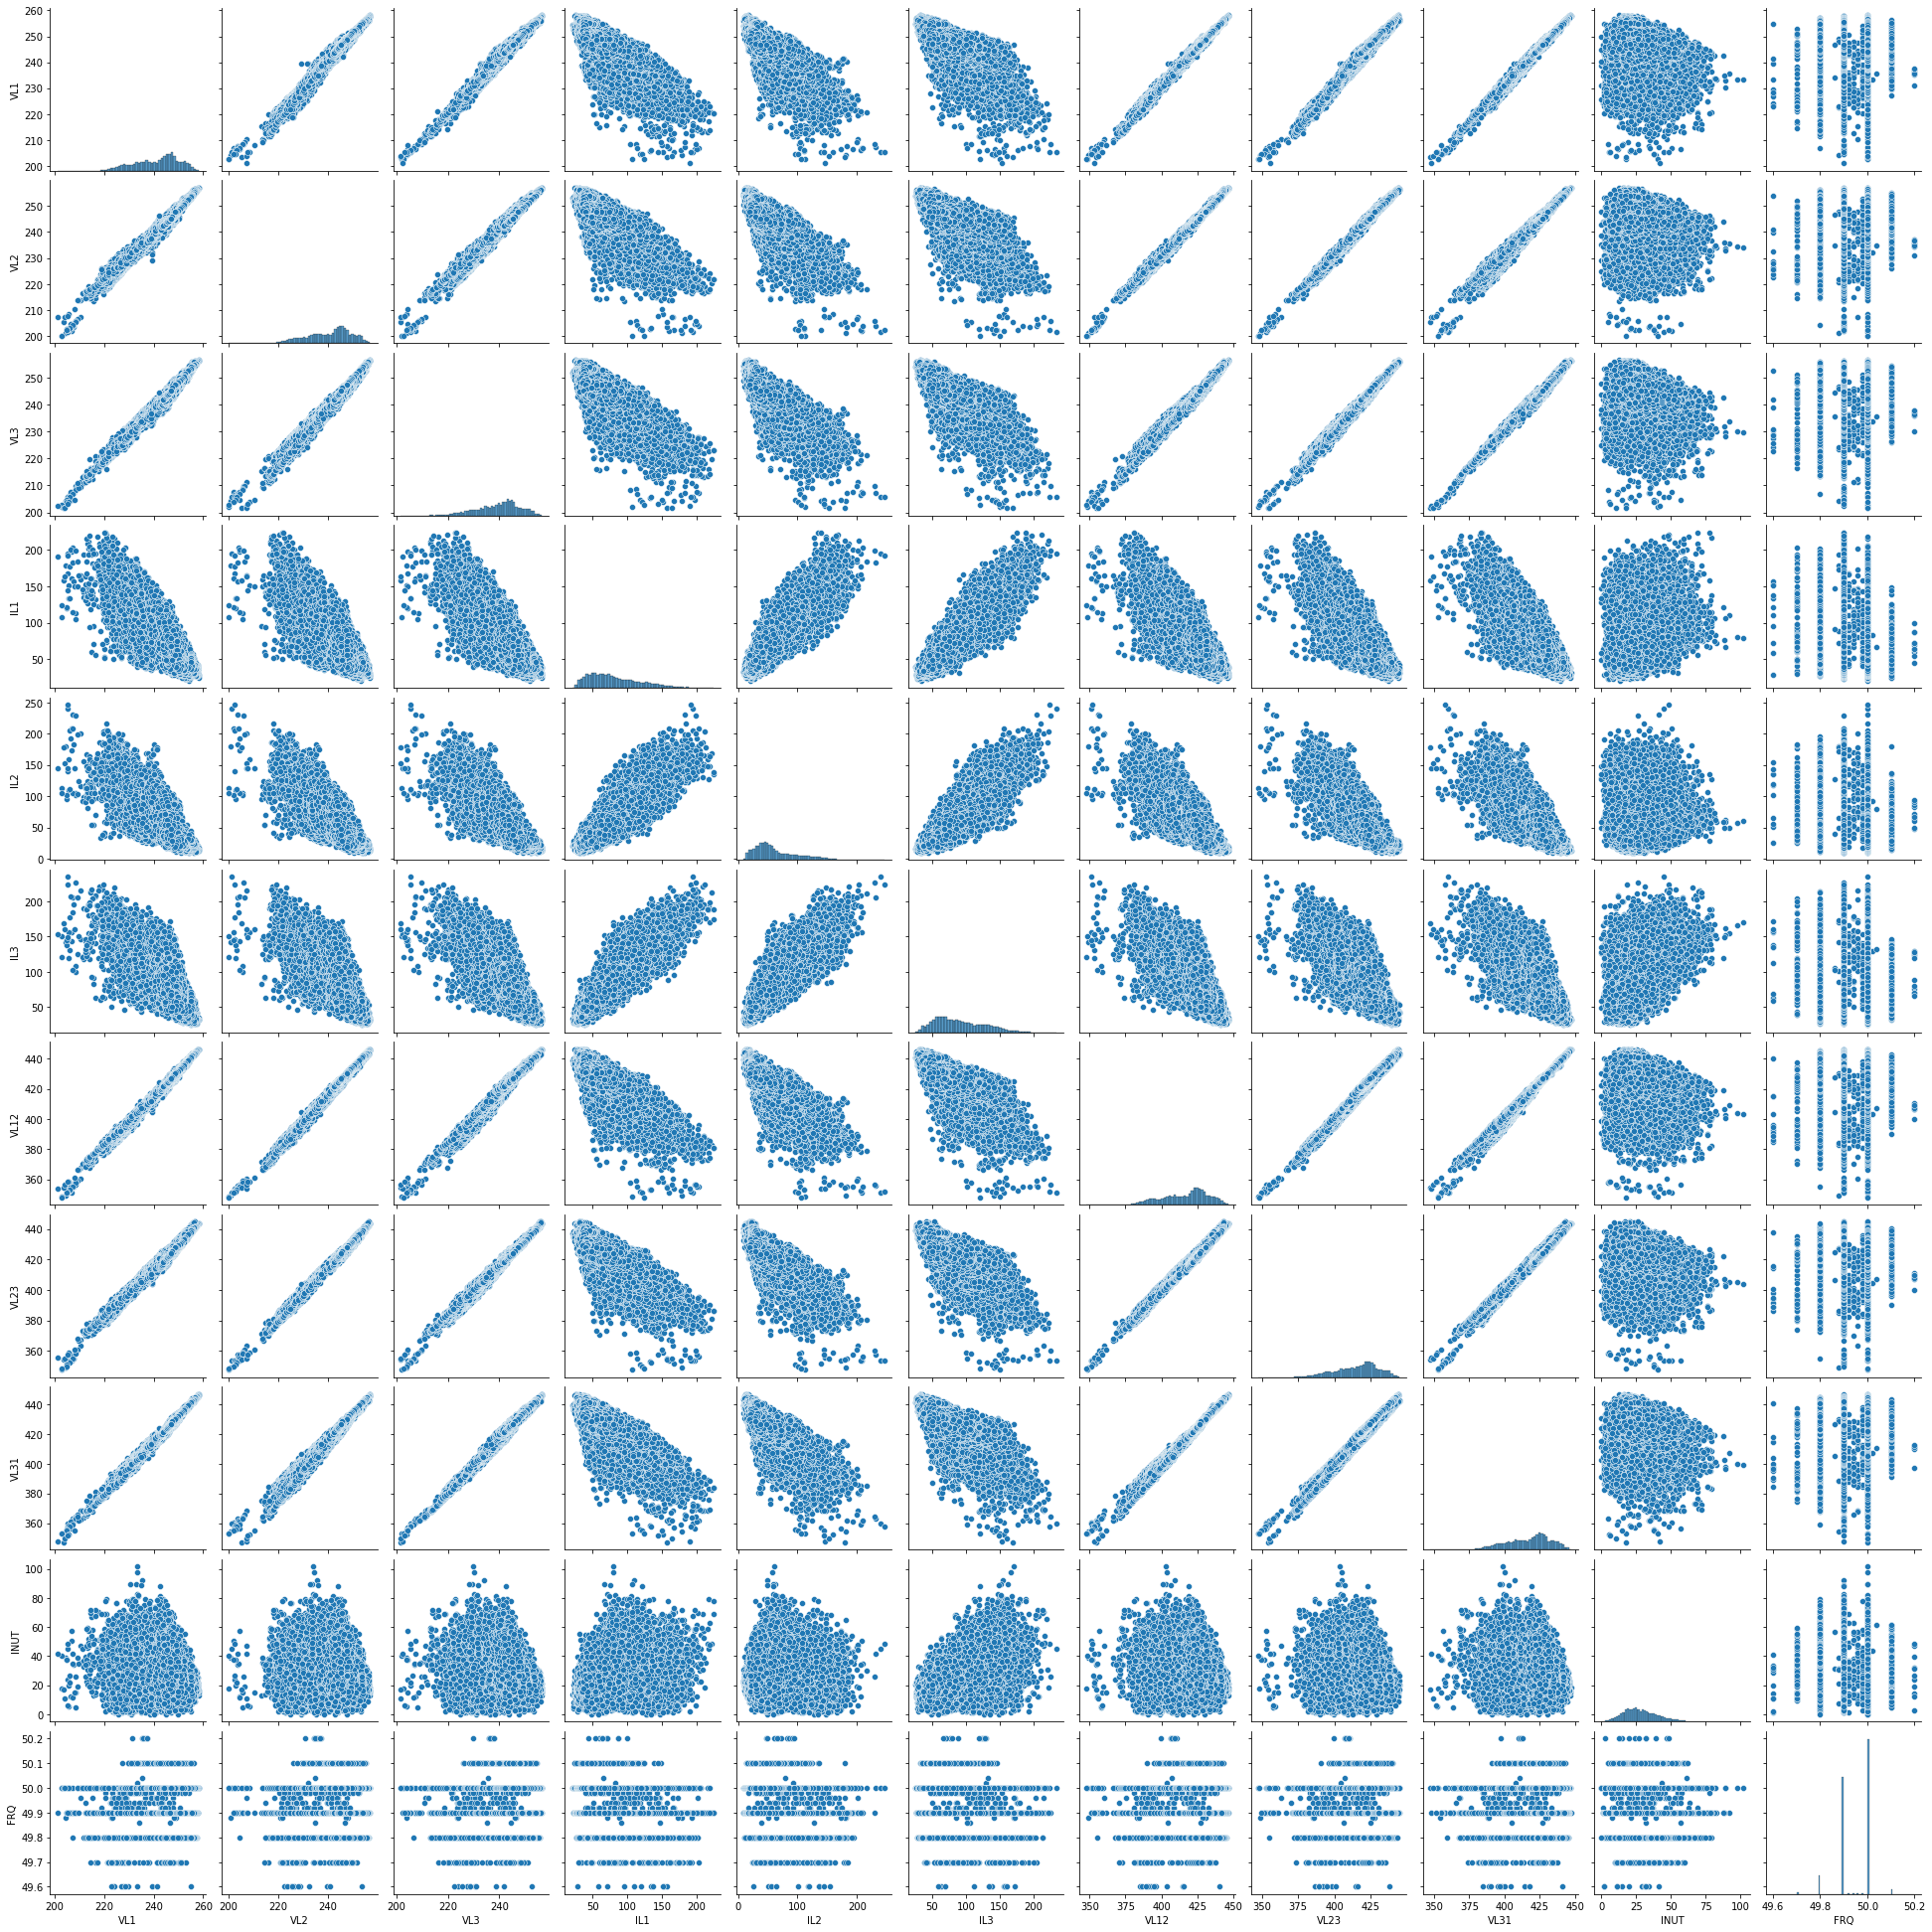

In [60]:
# A lot of noise has been removed from data. Still we need to deeply look into current variance problem. Many noise can be seen.
# Each of the noise belong t0 a trigger category and needs identification for post model inferences.

sns.pairplot(data)

In [61]:
# INUT has zero value. 
data.describe()

VL1           VL2           VL3          IL1           IL2  \
count  17333.000000  17333.000000  17333.000000  17333.00000  17333.000000   
mean     241.070490    240.482790    239.772999     81.01016     64.811371   
std        8.999515      8.762827      8.229983     35.78261     37.578256   
min      201.000000    200.200000    201.600000     20.70000      9.400000   
25%      234.600000    234.300000    234.400000     52.80000     37.200000   
50%      243.000000    242.400000    241.100000     73.80000     53.800000   
75%      247.800000    246.900000    245.500000    103.80000     87.200000   
max      258.100000    257.000000    256.500000    224.10000    246.700000   

                IL3          VL12          VL23          VL31          INUT  \
count  17333.000000  17333.000000  17333.000000  17333.000000  17333.000000   
mean      91.449149    416.825524    415.715537    417.334772     28.780805   
std       36.517949     15.513146     14.427496     15.156046     13.057777   
min       24.800000    348.100000    347.600000    347.200000      0.000000   
25%       62.400000    405.800000    406.000000    406.700000     19.400000   
50%       85.400000    420.200000    418.300000    420.200000     27.000000   
75%      118.100000    428.300000    425.900000    428.400000     36.700000   
max      234.400000    446.300000    444.800000    447.300000    101.800000   

                FRQ  
count  17333.000000  
mean      49.948387  
std        0.066799  
min       49.600000  
25%       49.900000  
50%       50.000000  
75%       50.000000  
max       50.200000

In [62]:
# Neutral current is zero in case of balanced load condition. But needs domain clarity here. For now assuming condition 
# is possible and normal.

data[data['INUT'] == 0.0]

VL1    VL2    VL3    IL1    IL2    IL3   VL12   VL23   VL31  INUT  \
3450   230.9  229.2  231.1  147.6  147.6  148.3  398.7  399.2  402.5   0.0   
5165   225.7  225.0  225.0  128.1  128.1  126.9  390.5  389.8  391.1   0.0   
8543   238.7  235.3  236.3  127.5  128.0  127.4  410.6  409.1  411.5   0.0   
10899  249.7  247.6  247.7   48.9   48.8   49.0  430.1  428.7  430.7   0.0   
11307  240.1  238.6  238.3  133.9  135.0  135.0  414.9  412.7  415.4   0.0   
16391  244.8  243.0  243.8   58.5   59.2   58.5  422.3  421.8  424.0   0.0   

        FRQ  
3450   50.0  
5165   50.0  
8543   50.0  
10899  50.0  
11307  50.0  
16391  49.8

In [63]:
# Adding a small delta to neutral current zero to avoid log zero condition on transformation.

data.loc[data[data['INUT'] == 0.0].index,'INUT'] = 0.01

In [64]:
# Assumption: Considering that after outlier removal the data points available are legitimate and model needs to learn those reconstruction.

# Applying logarithmic transformation to reduce variance in data
data = np.log(data)

In [65]:
data.describe()

VL1           VL2           VL3           IL1           IL2  \
count  17333.000000  17333.000000  17333.000000  17333.000000  17333.000000   
mean       5.484382      5.481975      5.479095      4.297053      4.003049   
std        0.037765      0.036855      0.034697      0.447074      0.594215   
min        5.303305      5.299317      5.306286      3.030134      2.240710   
25%        5.457882      5.456602      5.457029      3.966511      3.616309   
50%        5.493061      5.490589      5.485212      4.301359      3.985273   
75%        5.512622      5.508983      5.503297      4.642466      4.468204   
max        5.553347      5.549076      5.547129      5.412092      5.508173   

                IL3          VL12          VL23          VL31          INUT  \
count  17333.000000  17333.000000  17333.000000  17333.000000  17333.000000   
mean       4.433534      6.031965      6.029390      6.033220      3.239962   
std        0.413157      0.037641      0.035091      0.036725      0.541963   
min        3.210844      5.852490      5.851052      5.849901     -4.605170   
25%        4.133565      6.005860      6.006353      6.008076      2.965273   
50%        4.447346      6.040731      6.036199      6.040731      3.295837   
75%        4.771532      6.059824      6.054205      6.060057      3.602777   
max        5.457029      6.100991      6.097625      6.103230      4.623010   

                FRQ  
count  17333.000000  
mean       3.910989  
std        0.001338  
min        3.903991  
25%        3.910021  
50%        3.912023  
75%        3.912023  
max        3.916015

In [66]:
std_scaler = StandardScaler()
data_transformed = std_scaler.fit_transform(data)
data_transformed_df = pd.DataFrame(data_transformed,columns=feature_column)
data_transformed_df.columns = feature_column
data_transformed_df.index = data.index

data_transformed_df.describe()

VL1           VL2           VL3           IL1           IL2  \
count  1.733300e+04  1.733300e+04  1.733300e+04  1.733300e+04  1.733300e+04   
mean   1.325570e-14  6.067058e-15  1.255389e-14 -6.854136e-16  8.854626e-16   
std    1.000029e+00  1.000029e+00  1.000029e+00  1.000029e+00  1.000029e+00   
min   -4.795005e+00 -4.956225e+00 -4.980680e+00 -2.833882e+00 -2.965912e+00   
25%   -7.017319e-01 -6.884506e-01 -6.359843e-01 -7.393659e-01 -6.508602e-01   
50%    2.298382e-01  2.337482e-01  1.762918e-01  9.630748e-03 -2.991445e-02   
75%    7.478102e-01  7.328537e-01  6.975382e-01  7.726293e-01  7.828296e-01   
max    1.826231e+00  1.820726e+00  1.960846e+00  2.494152e+00  2.533035e+00   

                IL3          VL12          VL23          VL31          INUT  \
count  1.733300e+04  1.733300e+04  1.733300e+04  1.733300e+04  1.733300e+04   
mean   1.311796e-16 -1.493480e-14 -1.137328e-14 -1.452159e-14 -6.952521e-16   
std    1.000029e+00  1.000029e+00  1.000029e+00  1.000029e+00  1.000029e+00   
min   -2.959468e+00 -4.768253e+00 -5.082264e+00 -4.991743e+00 -1.447582e+01   
25%   -7.260606e-01 -6.935351e-01 -6.565083e-01 -6.846600e-01 -5.068556e-01   
50%    3.343218e-02  2.328932e-01  1.940338e-01  2.045315e-01  1.030998e-01   
75%    8.181093e-01  7.401545e-01  7.071596e-01  7.307913e-01  6.694644e-01   
max    2.477326e+00  1.833883e+00  1.944546e+00  1.906365e+00  2.551996e+00   

                FRQ  
count  1.733300e+04  
mean  -4.591533e-13  
std    1.000029e+00  
min   -5.230795e+00  
25%   -7.237423e-01  
50%    7.725893e-01  
75%    7.725893e-01  
max    3.756295e+00

### Data points more than 3 std_dev away.

In [67]:
# Removing data points more than 3 std dev 
upper_limit = data.mean() + 3 * data.std()
lower_limit = data.mean() - 3 * data.std()

In [68]:
print('UPPER LIMIT:\n {}'.format(upper_limit))
print('\n Lower LIMIT:\n {}'.format(lower_limit))

UPPER LIMIT:
 VL1     5.597676
VL2     5.592540
VL3     5.583186
IL1     5.638276
IL2     5.785694
IL3     5.673005
VL12    6.144887
VL23    6.134664
VL31    6.143396
INUT    4.865852
FRQ     3.915003
dtype: float64

 Lower LIMIT:
 VL1     5.371088
VL2     5.371409
VL3     5.375004
IL1     2.955830
IL2     2.220403
IL3     3.194062
VL12    5.919043
VL23    5.924116
VL31    5.923043
INUT    1.614073
FRQ     3.906975
dtype: float64


In [69]:
upper_limit_outlier_index = list()
lower_limit_outlier_index = list()

upper_limit_feature_dict = dict()
lower_limit_feature_dict = dict()

for row_index in data.index:
    upper_limit_check = (data.loc[row_index] > upper_limit)
    lower_limit_check = (data.loc[row_index] < lower_limit)
    if True in upper_limit_check.values:
        upper_limit_outlier_index.append(row_index)
        upper_limit_feature_dict[row_index] = [k for k,v in upper_limit_check.items() if v==True]
                
    if True in lower_limit_check.values:
        lower_limit_outlier_index.append(row_index)
        lower_limit_feature_dict[row_index] = [k for k,v in lower_limit_check.items() if v==True]

In [70]:
print('Upper_limit_outlier: {}'.format(len(upper_limit_outlier_index)))
print('lower_limit_outlier: {}'.format(len(lower_limit_outlier_index)))

Upper_limit_outlier: 11
lower_limit_outlier: 365


In [71]:
upper_limit_feature_dict.values()

dict_values([['FRQ'], ['FRQ'], ['FRQ'], ['FRQ'], ['FRQ'], ['FRQ'], ['FRQ'], ['FRQ'], ['FRQ'], ['FRQ'], ['FRQ']])

In [72]:
# Outliers in lower range points are due to voltage dip and neutral current. Needs to identify these scenarios to eliminate anomaly scenario.
lower_limit_feature_dict.values()

dict_values([['INUT'], ['INUT'], ['INUT'], ['INUT'], ['FRQ'], ['FRQ'], ['FRQ'], ['FRQ'], ['INUT'], ['FRQ'], ['INUT'], ['INUT'], ['INUT'], ['INUT'], ['INUT'], ['FRQ'], ['FRQ'], ['FRQ'], ['FRQ'], ['FRQ'], ['INUT'], ['INUT'], ['INUT'], ['FRQ'], ['FRQ'], ['FRQ'], ['VL1', 'VL2', 'VL3', 'VL12', 'VL23', 'VL31'], ['VL1', 'VL2', 'VL3', 'VL12', 'VL23', 'VL31'], ['VL1', 'VL2', 'VL3', 'VL12', 'VL23', 'VL31'], ['INUT'], ['INUT'], ['INUT'], ['FRQ'], ['FRQ'], ['INUT'], ['FRQ'], ['INUT'], ['INUT'], ['INUT'], ['INUT'], ['FRQ'], ['INUT'], ['INUT'], ['FRQ'], ['VL1', 'VL2', 'VL3', 'VL12', 'VL23', 'VL31'], ['VL1', 'VL2', 'VL3', 'VL12', 'VL23', 'VL31'], ['VL1', 'VL2', 'VL3', 'VL12', 'VL23', 'VL31'], ['VL1', 'VL2', 'VL3', 'VL12', 'VL23', 'VL31'], ['VL1', 'VL2', 'VL3', 'VL12', 'VL23', 'VL31'], ['VL1', 'VL2', 'VL3', 'VL12', 'VL23', 'VL31'], ['VL1', 'VL2', 'VL3', 'VL12', 'VL23', 'VL31'], ['VL1', 'VL2', 'VL3', 'VL12', 'VL23', 'VL31'], ['VL1', 'VL2', 'VL3', 'VL12', 'VL23', 'VL31'], ['VL1', 'VL2', 'VL3', 'VL12', '

In [73]:
# How many points matching both high current as well as low voltage scenario

low_vtg_high_current_index = [current_index for voltage_index in list(lower_limit_feature_dict.keys()) for current_index in list(upper_limit_feature_dict.keys()) if current_index == voltage_index]
print('Matched Index',low_vtg_high_current_index)

print('\n')

print('Low Voltage- High current count: {}'.format(len(low_vtg_high_current_index)))

Matched Index [7378]


Low Voltage- High current count: 1


In [74]:
# One way to avoid lossing pattern would be to use moving average. Note: can not apply moving average directly it has to be based 
# on each cluster level.
lower_limit_feature_dict.keys()

dict_keys([1724, 1840, 1860, 1872, 2020, 2073, 2075, 2081, 2114, 2254, 2256, 2309, 2310, 2316, 2332, 2362, 2371, 2447, 2448, 2451, 2495, 2511, 2526, 2533, 2551, 2552, 2580, 2581, 2582, 2604, 2639, 2689, 2827, 2880, 2973, 2980, 3054, 3058, 3068, 3070, 3156, 3158, 3229, 3274, 3355, 3356, 3357, 3358, 3359, 3362, 3363, 3364, 3365, 3366, 3367, 3450, 3495, 3558, 3561, 3578, 3682, 3683, 3726, 3756, 3760, 3774, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3845, 3846, 3849, 3932, 3933, 3946, 3970, 3987, 3988, 4218, 4219, 4397, 4413, 4489, 4508, 4510, 4513, 4566, 4605, 4606, 4670, 4671, 4674, 4675, 4690, 4691, 4701, 4703, 4704, 4722, 4753, 4964, 4973, 4980, 4998, 4999, 5054, 5056, 5076, 5103, 5157, 5158, 5165, 5175, 5263, 5286, 5295, 5382, 5390, 5462, 5471, 5535, 5659, 5741, 5742, 5828, 5829, 5939, 6033, 6034, 6135, 6209, 6244, 6348, 6350, 6400, 6458, 6495, 6496, 6502, 6504, 6513, 6740, 6759, 6888, 6941, 6954, 7082, 7123, 7126, 7195, 7196, 7197, 7199, 7200, 7201, 7202, 7203,

In [75]:
# Some of the points in close proximity are also having higher values
imputed_merged_df.loc[list(upper_limit_feature_dict.keys())]

VL1    VL2    VL3    IL1   IL2    IL3   VL12   VL23   VL31  INUT  \
1935  236.9  237.3  236.6   59.7  63.0   76.3  410.6  410.7  410.5  14.5   
4181  237.2  236.4  237.8   44.7  46.9   69.7  408.4  409.3  411.9  24.2   
4182  236.6  236.1  237.6   54.8  49.9   70.8  408.2  409.6  411.6  19.4   
4183  236.0  235.5  236.9   64.5  60.3   88.5  408.3  409.5  411.8  26.6   
4184  236.0  235.4  237.0   69.6  67.8   80.3  406.9  408.6  410.4  12.4   
4185  235.9  235.2  236.3   71.4  71.8  124.0  406.5  407.6  410.5  47.2   
4186  235.6  234.5  235.9   71.6  82.5  126.1  407.3  407.9  411.4  48.2   
4187  235.3  234.5  235.9   87.6  86.5  119.1  406.4  407.3  410.2  31.9   
4188  235.8  234.8  236.4   87.7  90.8  129.2  407.0  407.9  411.1  39.3   
4211  237.4  236.8  237.9  100.0  94.2  128.1  409.2  410.0  412.6  31.7   
7378  231.1  230.9  230.0   63.9  66.1   65.8  399.8  399.6  397.5   2.4   

       FRQ     DeviceTimeStamp        Date  Hour  Minutes  Month  DayOfWeek  \
1935  50.2 2019-07-16 08:00:00  2019-07-16     8        0      7          1   
4181  50.2 2019-08-15 09:30:00  2019-08-15     9       30      8          3   
4182  50.2 2019-08-15 09:45:00  2019-08-15     9       45      8          3   
4183  50.2 2019-08-15 10:00:00  2019-08-15    10        0      8          3   
4184  50.2 2019-08-15 10:15:00  2019-08-15    10       15      8          3   
4185  50.2 2019-08-15 10:30:00  2019-08-15    10       30      8          3   
4186  50.2 2019-08-15 10:45:00  2019-08-15    10       45      8          3   
4187  50.2 2019-08-15 11:00:00  2019-08-15    11        0      8          3   
4188  50.2 2019-08-15 11:15:00  2019-08-15    11       15      8          3   
4211  50.2 2019-08-15 17:15:00  2019-08-15    17       15      8          3   
7378  50.2 2019-09-29 10:15:00  2019-09-29    10       15      9          6   

     data_collection_frequency  
1935           0 days 00:05:00  
4181           0 days 00:15:00  
4182           0 days 00:15:00  
4183           0 days 00:15:00  
4184           0 days 00:15:00  
4185           0 days 00:15:00  
4186           0 days 00:15:00  
4187           0 days 00:15:00  
4188           0 days 00:15:00  
4211           0 days 00:15:00  
7378           0 days 00:15:00

In [76]:
## 
imputed_merged_df.loc[list(lower_limit_feature_dict.keys())]

VL1    VL2    VL3    IL1    IL2    IL3   VL12   VL23   VL31  INUT  \
1724   235.0  236.4  235.3  123.6  120.0  118.1  407.5  408.6  406.6   4.6   
1840   240.7  240.6  240.0   42.3   46.3   47.7  415.7  415.3  415.5   4.9   
1860   235.3  235.0  234.9   66.6   71.0   68.4  407.6  407.7  408.0   3.3   
1872   233.2  233.4  232.5   76.9   75.7   78.2  404.8  404.6  404.3   2.9   
2020   239.5  239.6  238.9   58.1   50.6   63.0  414.9  414.2  414.5  11.1   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...   ...   
18142  248.4  246.7  246.2   41.4   38.6   43.3  428.7  426.7  429.3   2.5   
18204  247.2  246.3  245.5   93.9   54.9   79.5  428.0  424.5  428.2  33.9   
18464  247.6  247.3  245.0   81.5   40.5   80.9  428.7  424.8  428.8  40.9   
18555  246.3  245.5  242.6   66.3   44.9   88.3  424.8  421.7  426.1  37.3   
18922  246.6  247.1  244.1   97.5   36.8   96.3  427.9  423.4  427.6  59.7   

        FRQ     DeviceTimeStamp        Date  Hour  Minutes  Month  DayOfWeek  \
1724   50.0 2019-07-13 17:45:00  2019-07-13    17       45      7          5   
1840   50.1 2019-07-15 07:00:00  2019-07-15     7        0      7          0   
1860   50.0 2019-07-15 12:00:00  2019-07-15    12        0      7          0   
1872   50.0 2019-07-15 14:45:00  2019-07-15    14       45      7          0   
2020   49.6 2019-07-17 06:15:00  2019-07-17     6       15      7          2   
...     ...                 ...         ...   ...      ...    ...        ...   
18142  49.9 2020-04-01 07:00:00  2020-04-01     7        0      4          2   
18204  49.7 2020-04-01 22:30:00  2020-04-01    22       30      4          2   
18464  49.7 2020-04-04 23:00:00  2020-04-04    23        0      4          5   
18555  49.7 2020-04-05 21:15:00  2020-04-05    21       15      4          6   
18922  49.7 2020-04-09 22:30:00  2020-04-09    22       30      4          3   

      data_collection_frequency  
1724            0 days 00:15:00  
1840            0 days 00:15:00  
1860            0 days 00:15:00  
1872            0 days 00:15:00  
2020            0 days 00:15:00  
...                         ...  
18142           0 days 00:15:00  
18204           0 days 00:15:00  
18464           0 days 00:15:00  
18555           0 days 00:15:00  
18922           0 days 00:15:00  

[365 rows x 18 columns]

### These points falling outside 3 std are crucial for model performance and needs point by point analysis and marking under each of the Trigger point category

### Iteration 1: Assuming data we have so far after dropping idenfied condition are legitimate and has no anomaly.

In [79]:
### Dataset Version 1:
imputed_merged_df.loc[data.loc[data_transformed_df.index].index].to_csv('../data/Imputed_Merged_Data_V_1.csv')

In [78]:
## Training AutoEncoder model using AUTOML for hyperparameter for training and MLflow for logging params, metric and registring Models

# ! python AutoEncoder.py


## Iteration1 : Model Inference

In [80]:
from model_inference import ModelInference
import utility


In [81]:
data_v1 = pd.read_csv('../data/Imputed_Merged_Data_V_1.csv', index_col=[0])


# Values Derrived from the best performing model

run_id = 'logs/mlruns/1/9bfba4807e4046dd990c00219ab929a9/artifacts/Model'
input_width = 8
batch_size = 128

feature_column = ['VL1', 'VL2', 'VL3', 'IL1', 'IL2', 'IL3', 'VL12','VL23', 'VL31', 'INUT', 'FRQ']
time_column = 'DeviceTimeStamp'

scaler_path = 'dumps/min_max_scaler.pkl'

inference = ModelInference(input_width,batch_size,feature_column,time_column, run_id,scaler_path)

In [82]:
inference = ModelInference(input_width,batch_size,feature_column,time_column, run_id,scaler_path)

In [83]:
## Validating Train dataset to understand the points with high reconstruction loss and diagnosing the same

# Train-Test split
train, test = utility.split_train_test_data(data_v1, split_ratio = 0.8)

mse_loss, feature_mse_loss, feature_loss_dict  = inference.get_mse_loss(train, 'data_collection_frequency')

Clusters: cluster_0, Shape: (61, 18)
Clusters: cluster_1, Shape: (66, 18)
Clusters: cluster_2, Shape: (54, 18)
Clusters: cluster_3, Shape: (113, 18)
Clusters: cluster_4, Shape: (376, 18)
Clusters: cluster_5, Shape: (6, 18)
Clusters: cluster_6, Shape: (228, 18)
Clusters: cluster_7, Shape: (587, 18)
Clusters: cluster_8, Shape: (77, 18)
Clusters: cluster_9, Shape: (400, 18)
Clusters: cluster_10, Shape: (926, 18)
Clusters: cluster_11, Shape: (64, 18)
Clusters: cluster_12, Shape: (36, 18)
Clusters: cluster_13, Shape: (49, 18)
Clusters: cluster_14, Shape: (511, 18)
Clusters: cluster_15, Shape: (1106, 18)
Clusters: cluster_16, Shape: (6, 18)
Clusters: cluster_17, Shape: (520, 18)
Clusters: cluster_18, Shape: (89, 18)
Clusters: cluster_19, Shape: (1247, 18)
Clusters: cluster_20, Shape: (898, 18)
Clusters: cluster_21, Shape: (615, 18)
Clusters: cluster_22, Shape: (31, 18)
Clusters: cluster_23, Shape: (481, 18)
Clusters: cluster_24, Shape: (5, 18)
Clusters: cluster_25, Shape: (1009, 18)
Clusters

### Analysis of MSE distribution for each features. 

- Losses shows long tail for many features, which means many data points reconstruction loss was high
- High reconstruction loss can be because of abnormal points present in the data set or some legitimate scenarios with lesser
representative samples.
- INeutral shows peak at 0.1, which means abnoramilities arising due to Neutral current needs to be identified and flagged to avoid training in unusual scenario
- IL1 and IL3 shows very long tail. Scenarios of very high mse value needs to be clearly bifurcated.
- Freequency has peak at 0.1. Again legitimate scenario needs to be drilled down.


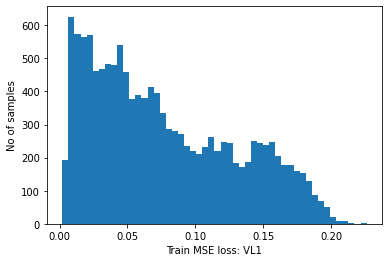

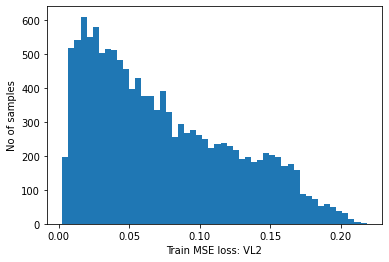

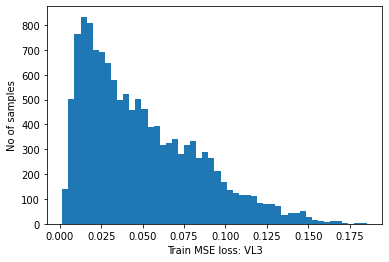

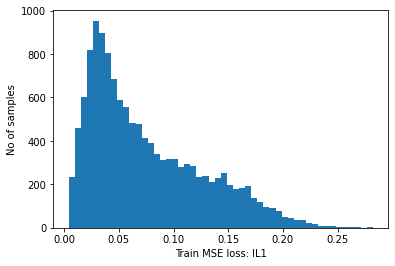

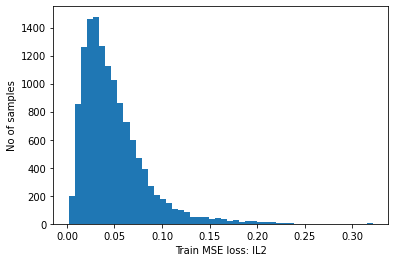

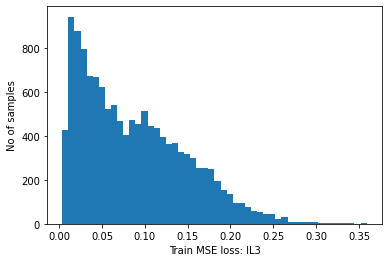

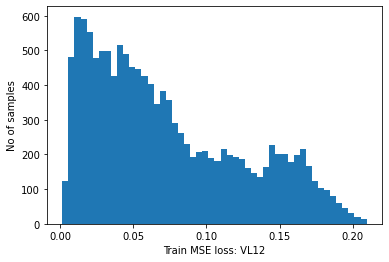

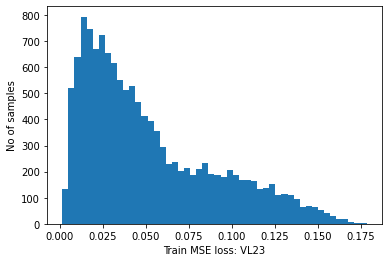

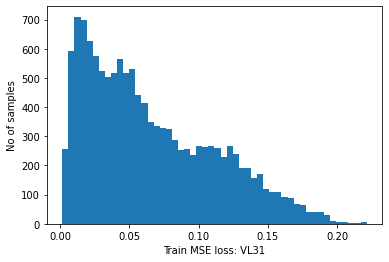

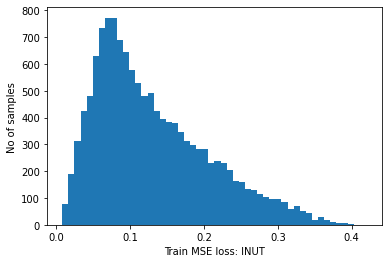

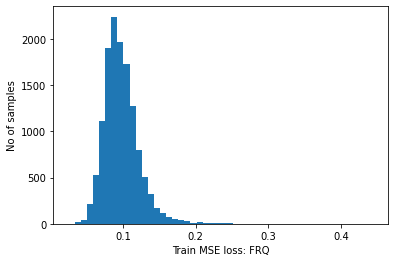

In [84]:


for i in feature_column:
    inference.plot_mse_loss(feature_loss_dict,i)

### Diagnosis: Latent representation of data points 

Clusters: cluster_0, Shape: (61, 18)
Clusters: cluster_1, Shape: (66, 18)
Clusters: cluster_2, Shape: (54, 18)
Clusters: cluster_3, Shape: (113, 18)
Clusters: cluster_4, Shape: (376, 18)
Clusters: cluster_5, Shape: (6, 18)
Clusters: cluster_6, Shape: (228, 18)
Clusters: cluster_7, Shape: (587, 18)
Clusters: cluster_8, Shape: (77, 18)
Clusters: cluster_9, Shape: (400, 18)
Clusters: cluster_10, Shape: (926, 18)
Clusters: cluster_11, Shape: (64, 18)
Clusters: cluster_12, Shape: (36, 18)
Clusters: cluster_13, Shape: (49, 18)
Clusters: cluster_14, Shape: (511, 18)
Clusters: cluster_15, Shape: (1106, 18)
Clusters: cluster_16, Shape: (6, 18)
Clusters: cluster_17, Shape: (520, 18)
Clusters: cluster_18, Shape: (89, 18)
Clusters: cluster_19, Shape: (1247, 18)
Clusters: cluster_20, Shape: (898, 18)
Clusters: cluster_21, Shape: (615, 18)
Clusters: cluster_22, Shape: (31, 18)
Clusters: cluster_23, Shape: (481, 18)
Clusters: cluster_24, Shape: (5, 18)
Clusters: cluster_25, Shape: (1009, 18)
Clusters

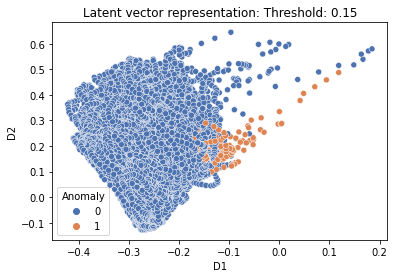

In [85]:
# Understanding what our Model has learnt, so initially verify with train data to bifurcate actual abnormality from the train dataset
# Higher the noise in training dataset,poor will be the performance of the model

# MSE loss threshold > 0.15 as anomaly

# Analysis:
# 1. Orange points represents high reconstruction loss points and marked as anomaly by algorithm. These points requires analysis on
# why it has been marked as anomaly. Best way to diagnose will be to plot feature reconstruction loss plot for these points and verify if they are actually anomaly.

# 2. Orange points lies outside the high probability region and so are its indication of model has converged well with hyperparameters

# 3. We also see many points lying outside the high probability region are not marked as anomaly by the algorithm. This is point of concern
# as these might not be normal data points but model has learnt resconstruction pattern of these data points. 

threshold = 0.15
model_inference, time_window = inference.plot_latent_vector(train, 'data_collection_frequency',threshold)

In [86]:
## Diagnosis of point 1 :Analyzing data points which are marked anomaly by algorithm

anomaly_points = np.where(model_inference==1)[0]
anomaly_index = anomaly_points[1]

In [87]:
# Note: We can see that the anomaly points can be seen in a sequence in most of the cases. Each of the sequence category needs to be
# mapped with triggers
anomaly_points

array([  78,   81,   82,   83,   84,  244,  245,  246,  247,  330,  331,
        332,  418,  419,  420,  421,  422,  423,  424,  425,  512,  513,
        514,  515,  516,  517,  518,  604,  605,  606,  607,  608,  745,
        746,  747,  748,  749,  750,  751,  752,  753,  754,  850, 1293,
       1294, 1295, 1296, 1297, 1298, 1299, 1483, 1484, 1485, 1486, 1534,
       1535, 1536, 1537, 1538, 1539, 1561, 1562, 1563, 1564, 1565, 1566,
       1567, 1568, 1569, 1660, 1661, 1662, 1663, 1664, 1665, 1735, 1736,
       1737, 1738, 1739, 1740, 1741, 1742, 1747, 1748, 1749, 1750, 1751,
       1752, 1753, 1754, 1755, 1756, 1757, 1854, 1855, 1856, 1857, 1858,
       1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1878, 2022, 2023,
       2024, 2025, 2026, 2027, 2028, 2215, 2216, 2217, 2218, 2219, 2312,
       2313, 2314, 2315, 2316, 2406, 2407, 2408, 2409, 2500, 2501, 2502,
       2503, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527,
       2592, 2593, 2594, 2595, 2596, 2597, 2598, 26

In [88]:
# Time series plot
anomaly_seq = train[train.DeviceTimeStamp.astype('str').isin([str(pd.to_datetime(i)) for i in time_window[anomaly_index]])]
anomaly_seq

VL1    VL2    VL3   IL1   IL2   IL3   VL12   VL23   VL31  INUT   FRQ  \
1938  235.5  236.0  235.4  75.0  53.8  65.0  407.2  407.0  406.3  18.9  49.9   
1939  233.6  234.3  233.3  69.8  48.0  66.7  406.5  406.1  406.2  20.4  50.0   
1940  233.2  233.6  232.8  55.9  44.5  64.2  405.6  405.1  405.0  17.7  49.8   
1941  233.3  233.8  233.2  61.8  48.8  60.5  402.8  402.8  402.3  12.4  49.8   
1942  231.7  232.1  231.3  61.8  47.9  66.0  403.6  403.0  402.8  16.5  49.9   
1943  232.2  232.3  231.6  63.4  90.6  71.0  400.3  400.7  400.2  26.3  50.0   
1944  231.7  231.8  231.2  68.1  96.2  81.1  400.8  401.1  400.9  24.2  49.9   
1945  229.8  229.7  229.0  82.6  90.9  96.5  399.5  398.7  399.2  12.1  50.0   

          DeviceTimeStamp        Date  Hour  Minutes  Month  DayOfWeek  \
1938  2019-07-16 08:45:00  2019-07-16     8       45      7          1   
1939  2019-07-16 09:00:00  2019-07-16     9        0      7          1   
1940  2019-07-16 09:15:00  2019-07-16     9       15      7          1   
1941  2019-07-16 09:30:00  2019-07-16     9       30      7          1   
1942  2019-07-16 09:45:00  2019-07-16     9       45      7          1   
1943  2019-07-16 10:00:00  2019-07-16    10        0      7          1   
1944  2019-07-16 10:15:00  2019-07-16    10       15      7          1   
1945  2019-07-16 10:30:00  2019-07-16    10       30      7          1   

     data_collection_frequency  
1938           0 days 00:15:00  
1939           0 days 00:15:00  
1940           0 days 00:15:00  
1941           0 days 00:15:00  
1942           0 days 00:15:00  
1943           0 days 00:15:00  
1944           0 days 00:15:00  
1945           0 days 00:15:00

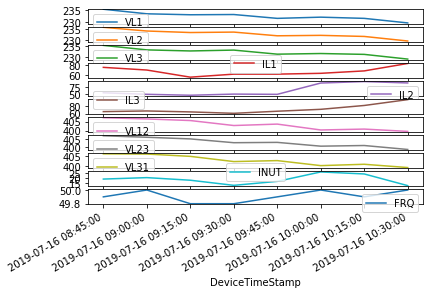

In [89]:
# Clearly frequency fluctuated from 50 to 49.8. voltages are continuously declining. Switching to high current value can be seen 
# in last steps
inference.plot_timeseries_sequence(train, time_window, anomaly_index)

Anomaly MSE : 0.15093814340969833


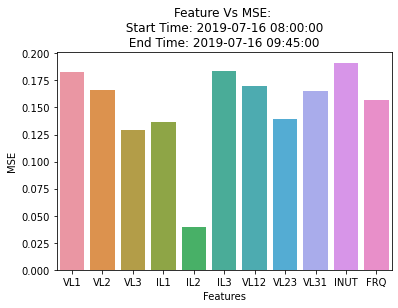

Anomaly MSE : 0.15043702845198956


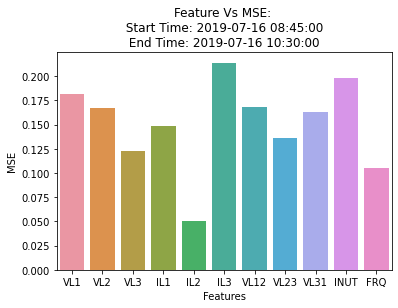

Anomaly MSE : 0.15277729207423515


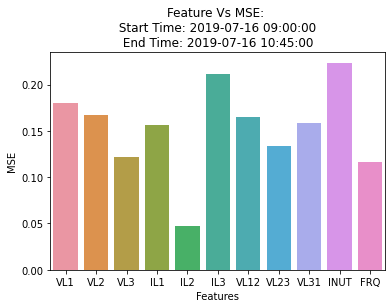

Anomaly MSE : 0.15285534378300003


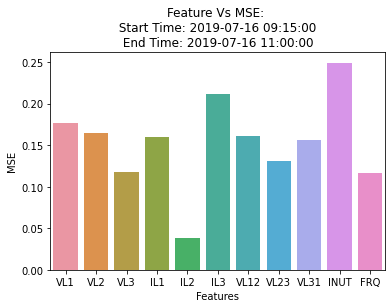

Anomaly MSE : 0.15061105692130564


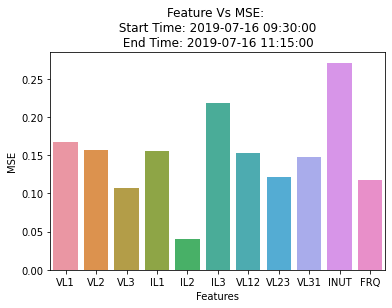

Anomaly MSE : 0.15437993551487364


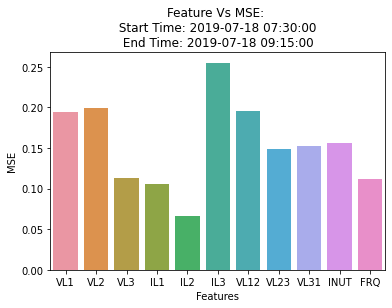

In [90]:
for i in anomaly_points[0:6]:
    inference.plot_feature_mse_basedon_index(mse_loss,feature_mse_loss, i, time_window)
    


# Next Iteration Steps:

Point 1. Identified points with high reconstruction loss that needs to be clearly identified as anomaly or not an anomaly. In case of not anomaly, lesser representation of such signals could be also a reason behind model not learning these points.

Point 2: Model Assesment via validating below for different threshold limits
1. Point specific loss
2. Feature Specific loss
3. Latent vector specific representation
4. Model specific errors
5. Data specific errors

Point 3: Try to analyse the temporal relationship between each of the time window. LSTM based model would be able to capture such relations if at all these exists

Point 4: Testing the robustness of the model via adding gaussian noise to the data. Robustness in model can be added via changing cost function for adversarial training 

Iteration 2 steps: <br>
1. Reduce unwanted noise by drop the clearly identified anomaly points and place in identified trigger clusters <br>
2. For lesser representative legitimate samples, create pertubation samples and retrain model including those.




